In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 18.0MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 19.4MB/s 


In [2]:
#!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1 -O erm.zip

--2021-03-03 16:58:49--  https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 40.108.195.27
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|40.108.195.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9TjJneW5tWGUyRWc [following]
--2021-03-03 16:58:50--  https://unirioja-my.sharepoint.com/personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9TjJneW5tWGUyRWc
Reusing existing connection to unirioja-my.share

In [3]:
!unzip erm.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: erm/train/no/anonymized_1873542_fakeB.jpg  
  inflating: erm/train/no/anonymized_887511_fakeB.jpg  
  inflating: erm/train/no/anonymized_1351887_fakeB.jpg  
  inflating: erm/train/no/anonymized_1099051_fakeB.jpg  
  inflating: erm/train/no/anonymized_448602_fakeB.jpg  
  inflating: erm/train/no/anonymized_852019_fakeB.jpg  
  inflating: erm/train/no/anonymized_169973_fakeB.jpg  
  inflating: erm/train/no/anonymized_1241994_fakeB.jpg  
  inflating: erm/train/no/anonymized_1898489_fakeB.jpg  
  inflating: erm/train/no/anonymized_160483_fakeB.jpg  
  inflating: erm/train/no/anonymized_593874_fakeB.jpg  
  inflating: erm/train/no/anonymized_359235_fakeB.jpg  
  inflating: erm/train/no/anonymized_782889_fakeB.jpg  
  inflating: erm/train/no/anonymized_324102_fakeB.jpg  
  inflating: erm/train/no/anonymized_532397_fakeB.jpg  
  inflating: erm/train/no/anonymized_263513_fakeB.jpg  
  inflating: erm/train/no/anonymized_1

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('erm/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=224):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='vit')
]

In [9]:
import timm
timm.list_models('*vit*')

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [10]:
import timm
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [11]:
learn = Learner(dls512,ViTBase16(2,True),metrics=accuracy,cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.0964781722577754e-06)

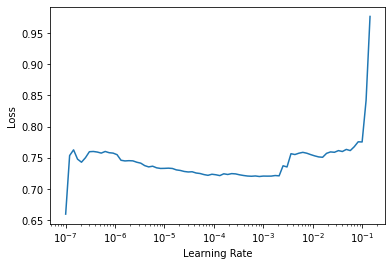

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.709653,0.693010,0.504202,03:42


Better model found at epoch 0 with valid_loss value: 0.6930100321769714.


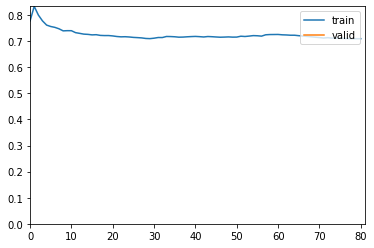

epoch,train_loss,valid_loss,accuracy,time
0,0.697917,0.697875,0.503438,03:42
1,0.697826,0.692309,0.505730,03:42
2,0.695118,0.691983,0.503438,03:42
3,0.689662,0.731988,0.498090,03:43
4,0.687317,0.718691,0.503438,03:42
5,0.682800,0.679802,0.571429,03:42
6,0.669923,0.678399,0.569901,03:42
7,0.657159,0.696921,0.616501,03:42
8,0.654747,0.659606,0.598167,03:43
9,0.630863,0.627777,0.640183,03:43


Better model found at epoch 0 with valid_loss value: 0.6978747844696045.


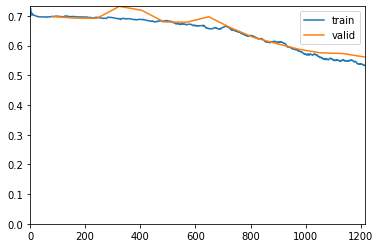

Better model found at epoch 1 with valid_loss value: 0.6923094391822815.
Better model found at epoch 2 with valid_loss value: 0.6919828057289124.
Better model found at epoch 5 with valid_loss value: 0.6798022985458374.
Better model found at epoch 6 with valid_loss value: 0.678399384021759.
Better model found at epoch 8 with valid_loss value: 0.6596060991287231.
Better model found at epoch 9 with valid_loss value: 0.6277768611907959.
Better model found at epoch 10 with valid_loss value: 0.6075232028961182.
Better model found at epoch 11 with valid_loss value: 0.5882965922355652.
Better model found at epoch 12 with valid_loss value: 0.5755191445350647.
Better model found at epoch 13 with valid_loss value: 0.5733257532119751.
Better model found at epoch 14 with valid_loss value: 0.5613798499107361.


In [12]:
learn.fine_tune(15,base_lr=1e-3)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

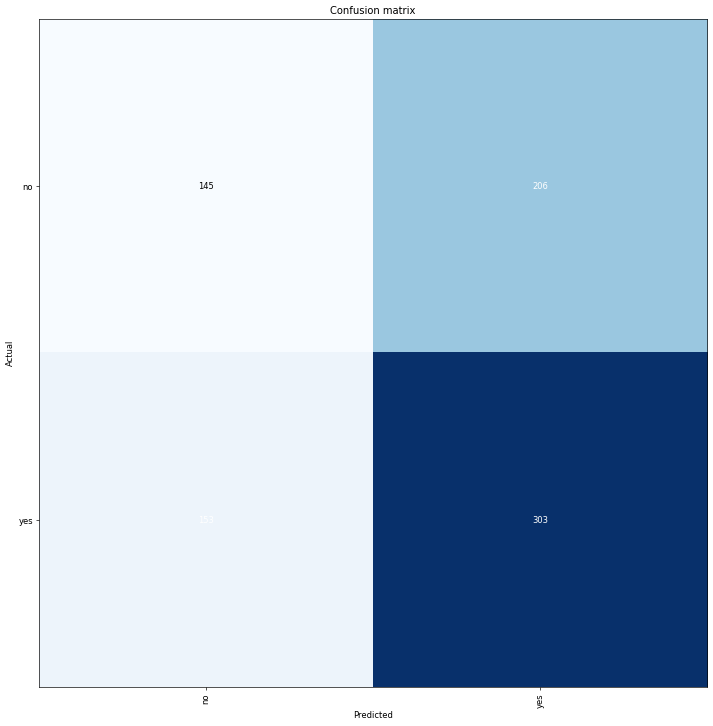

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.metrics=[accuracy,Precision(),Recall()]
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5551425218582153.


(#4) [0.7421506643295288,0.5551425218582153,0.5952848722986247,0.6644736842105263]

In [16]:
learn.export(fname='VIT.pkl')